In [609]:
import sys
sys.path.append("..")

import Essentials

In [610]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

In [611]:
data_archive = np.load('../Data_First.npz', allow_pickle=True)

In [612]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [613]:
X_test_1 = data_archive['X_test_1']
X_train_1 = data_archive['X_train_1']

X_test_2 = data_archive['X_test_2']
X_train_2 = data_archive['X_train_2']

X_test_3 = data_archive['X_test_3']
X_train_3 = data_archive['X_train_3']

Y_test_1, timestamp_test_1 = prepare_Y(data_archive['Y_test_1'])
Y_train_1, timestamp_train_1 = prepare_Y(data_archive['Y_train_1'])

Y_test_2, timestamp_test_2 = prepare_Y(data_archive['Y_test_2'])
Y_train_2, timestamp_train_2 = prepare_Y(data_archive['Y_train_2'])

Y_test_3, timestamp_test_3 = prepare_Y(data_archive['Y_test_3'])
Y_train_3, timestamp_train_3 = prepare_Y(data_archive['Y_train_3'])

C:\Users\PC\AppData\Local\Temp\ipykernel_1468\4096890530.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = y.astype(np.float64)


In [614]:
Y_train_2.shape

(75, 1)

In [615]:
X_train_2.shape

(75, 45)

In [616]:
class XGBoost(Essentials.SoftSensor):
    def __init__(self, x_train, y_train):
        super().__init__('Test')
        self.model = xgb.XGBRegressor()
        self.x_scaler = StandardScaler() 
        self.y_scaler = StandardScaler()
        self.fit_scaler(x_train, y_train)
        self.RandomizedSearchCV(x_train, y_train)
        self.train(x_train, y_train)
        self.set_model(self.model)

    def prepocessing(self, x):
        try:
            return self.x_scaler.transform(x)
        except:
            try:
               return self.y_scaler.transform(x)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err
            

    def postprocessing(self, x):
        try:
            return self.x_scaler.inverse_transform(x)
        except:
            try:
               return self.y_scaler.inverse_transform(x)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err

    def fit_scaler(self, x_train, y_train):
        self.x_scaler.fit(x_train)
        self.y_scaler.fit(y_train)

    def evaluate_model(self, x):
        predictions = self.get_model().predict(x)
        return predictions.reshape(-1,1)
    
    def RandomizedSearchCV(self,x_train,y_train):
        x_train_scaled = self.prepocessing(x_train) 
        y_train_scaled = self.prepocessing(y_train) 
        param_distributions = {
            'n_estimators': np.arange(50, 200, 50),
            'learning_rate': np.linspace(0.01, 0.1, num=10),
            'max_depth': np.arange(3, 6, 1),
            'min_child_weight': np.arange(1, 5, 1),
            'subsample': np.linspace(0.5, 0.8, num=4),
            'colsample_bytree': np.linspace(0.5, 0.8, num=4),
            'gamma': np.linspace(0, 0.5, num=5),
            'reg_alpha': np.linspace(0, 1, num=5),
            'reg_lambda': np.linspace(1, 4, num=5)
        }

        self.random_search = RandomizedSearchCV(
            estimator=self.model,
            param_distributions=param_distributions,
            n_iter=50,  # Количество итераций поиска. Увеличьте или уменьшите в зависимости от вычислительных ресурсов.
            scoring='neg_mean_squared_error',
            cv=3,  # Кросс-валидация по 3 блокам
            verbose=1,
            random_state=42,
            n_jobs=-1  # Используйте все доступные ядра
        )
        self.random_search.fit(x_train_scaled, y_train_scaled)
    
    def train(self, x_train, y_train):
        x_train_scaled = self.prepocessing(x_train) 
        y_train_scaled = self.prepocessing(y_train)
        self.model = xgb.XGBRegressor(**self.random_search.best_params_)
        self.model.fit(x_train_scaled,y_train_scaled)

    def __str__(self):
        return  

In [617]:
XGBoost_test = XGBoost(X_train_2, Y_train_2)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [618]:
metric = Essentials.R2Metric()

In [619]:
# print(PCA_LR_test)

In [620]:
XGBoost_test.test(X_test_2, Y_test_2, metric)

(array([[ 81.31494 ],
        [100.194855],
        [ 90.91606 ],
        [ 81.483376],
        [ 84.96813 ],
        [ 84.18994 ],
        [ 83.86579 ],
        [ 83.31799 ],
        [ 84.37312 ],
        [ 82.885056],
        [ 82.68111 ],
        [ 82.72182 ],
        [ 83.72624 ],
        [ 93.30674 ],
        [ 89.1101  ],
        [ 81.932396],
        [ 90.14921 ],
        [ 90.22487 ],
        [ 92.76133 ],
        [ 93.69036 ],
        [ 90.921165],
        [ 92.41345 ],
        [ 84.817215],
        [ 85.74523 ],
        [ 83.83931 ],
        [ 83.473694],
        [ 81.92841 ],
        [ 95.03156 ],
        [ 86.33014 ],
        [ 89.194595],
        [ 83.77786 ],
        [ 84.19351 ],
        [ 83.523224],
        [103.20995 ],
        [ 84.61769 ]], dtype=float32),
 0.42360464323052716)

In [621]:
XGBoost_test_visual_train = Essentials.Visualizer(X_train_2, Y_train_2, timestamp_train_2, [metric], 'XGBoost SoftSensor R2 metric on Train')

      Coefficient of determination
Test                       0.96452


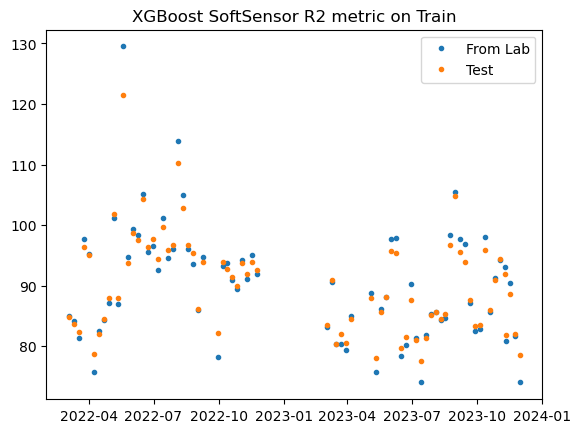

In [622]:
XGBoost_test_visual_train.visualize([XGBoost_test])

In [623]:
XGBoost_test_visual_test = Essentials.Visualizer(X_test_2, Y_test_2, timestamp_test_2, [metric], 'XGBoost SoftSensor R2 metric on Test')

      Coefficient of determination
Test                      0.423605


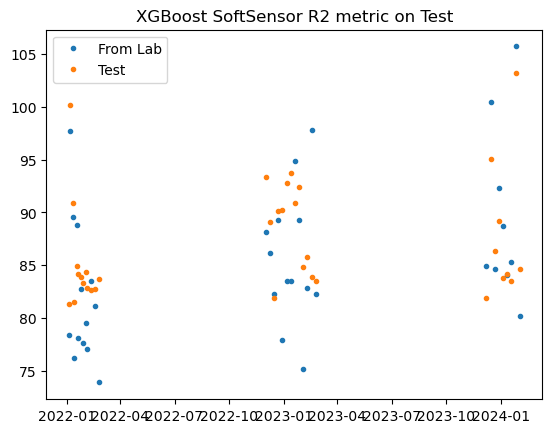

In [624]:
XGBoost_test_visual_test.visualize([XGBoost_test])